### Creating a Customized Machine Learning Model implementing Stochastic Gradient Descent using MNIST Database ###

---

#### **Name :** Denish Trivedi 
#### **Email Id :** denishtrivedi008@gmail.com / denishtrivedi@iitgn.ac.in ###

---

#### **Preparing the Data**

In [2]:
import numpy as np
import torch
import torchvision
from torchvision.datasets import MNIST

In [19]:
# MNIST dataset (images and labels)
import torchvision.transforms as transforms
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor())

<class 'torchvision.datasets.mnist.MNIST'>


In [25]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(dataset, [50000, 10000])

In [55]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

#### **Machile learning Model** 

In [24]:
import torch.nn as nn
import torch.nn.functional as F

input_size = 28*28
num_classes = 10

class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

#### **Training the Model** 

In [31]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        # model.epoch_end(epoch, result)
        history.append(result)

    return history

In [48]:
result0 = evaluate(model, val_loader)
history1 = fit(5, 0.001, model, train_loader, val_loader)
history2 = fit(5, 0.001, model, train_loader, val_loader)
history3 = fit(5, 0.001, model, train_loader, val_loader)
history4 = fit(5, 0.001, model, train_loader, val_loader)

history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]

#### **Plot of Accuracy**

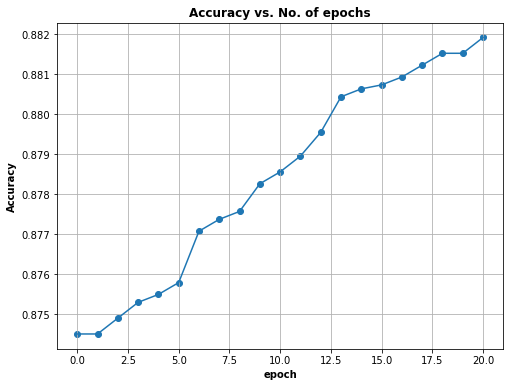

In [66]:
plt.figure(figsize=[8, 6])
plt.grid()
plt.plot(accuracies)
plt.scatter(np.arange(len(accuracies)), accuracies)
plt.xlabel('epoch', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Accuracy vs. No. of epochs', fontweight='bold');
plt.savefig('Accuracy')

As we can see from the figure as we increase the number of epochs the accuracy of our custom SGD model keeps increasong. Obviously there will be a saturation level as accuracy cannot exceed 100%.

#### **Testing on Sample Images** 
---
We can now test our model on actual samples from the MNIST database, for that we again have to create a testing dataset and transform it to a tensor using Pytorch to make predictions on it.

In [53]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

# Define test dataset
test_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor())

#### **Predictions**
---
We will test our model on 9 images from the MNIST database. 

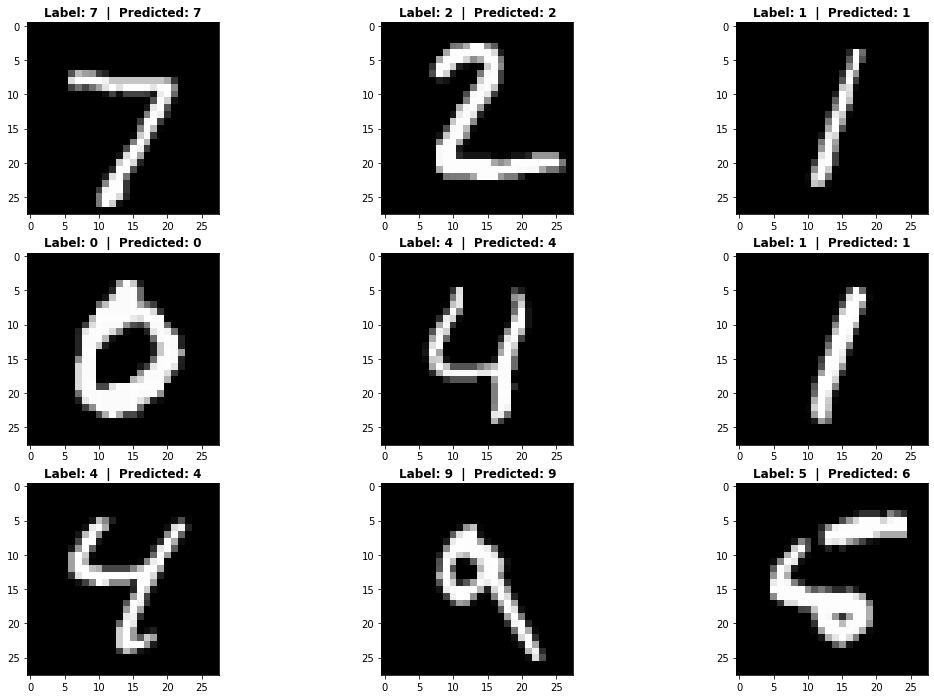

In [65]:
fig, ax = plt.subplots(3, 3, figsize=[18, 12])

a, b = 0, 0
for i in range(9):
    if b % 3 == 0 and i > 0:
        a += 1
        b = 0
    img, label = test_dataset[i]
    ax[a, b].imshow(img[0], cmap='gray')
    ax[a, b].set_title(f'Label: {label}  |  Predicted: {predict_image(img, model)}', fontweight='bold')
    b += 1
fig.savefig('myfig')